# Book Recommendation System – Data Cleaning & EDA


## Imports and Setup
# This section imports all necessary libraries and sets up the environment


In [178]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization
import sys  # For system-specific parameters and functions
from matplotlib.pyplot import loglog, xscale  # For log-scale plotting
from scipy.sparse import csr_matrix  # For sparse matrix operations
from scipy.sparse import save_npz  # For sparse matrix operations
import json

from recommender.collaborative_filtering import ratings
from utils.preprocessing import *
from utils.data_loader import *

## Load Data
# Loading the three main datasets: books, users, and ratings


In [179]:
books_df = load_books()  # Load book metadata (title, author, etc.)
users_df = load_users()  # Load user demographic data
ratings_df = load_ratings()  # Load user-book rating data


## Initial Exploration – Shape and Data Types
# Basic exploration of dataset shapes and data types to understand data structure


In [180]:
print(books_df.shape)  # Print dimensions of books dataframe
print(users_df.shape)  # Print dimensions of users dataframe
print(ratings_df.shape)  # Print dimensions of ratings dataframe

print(books_df.dtypes, "\n #########################")  # Print data types of book columns
print(users_df.dtypes, "\n #########################")  # Print data types of user columns
print(ratings_df.dtypes, "\n ########################")  # Print data types of rating columns


(271360, 8)
(278858, 3)
(1149780, 3)
ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object 
 #########################
User-ID       int64
Location     object
Age         float64
dtype: object 
 #########################
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object 
 ########################


## Check Unique Entries and Nulls
# Checking for unique identifiers and null values to assess data quality


In [181]:
print(books_df["ISBN"].nunique())  # Count unique book identifiers
print(users_df["User-ID"].nunique())  # Count unique user identifiers

print(books_df.isnull().sum(), "###################################")  # Count nulls in books
print(ratings_df.isnull().sum(), "###################################")  # Count nulls in ratings


271360
278858
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64 ###################################
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64 ###################################


## Clean Ratings – Replace 0 with NaN and Drop
# Cleaning the ratings by replacing 0 values (invalid) with NaN and dropping them


In [182]:
ratings_df = clean_ratings(ratings_df)

## Sanity Check – Invalid Ratings
# Verifying there are no ratings outside the valid range (1-10)


In [183]:
print(ratings_df[ratings_df["Book-Rating"] < 0])  # Check for negative ratings
print(ratings_df[ratings_df["Book-Rating"] > 10])  # Check for ratings above 10


Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating]
Index: []
Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating]
Index: []


## Clean Book Table – Drop Nulls and Duplicates 
# Cleaning the books dataset by removing nulls and duplicate titles


In [184]:
books_df = clean_books(books_df)

## Filter Ratings to Valid Books & Users
# Ensuring all ratings reference valid books and users (referential integrity)


In [185]:
ratings_df = filter_valid_ratings(ratings_df,books_df,users_df)

## EDA: Ratings Distribution
# to Understand how ratings are distributed across the scale (1-10)
# Insight: Shows if users tend to give higher/lower ratings, distribution patterns


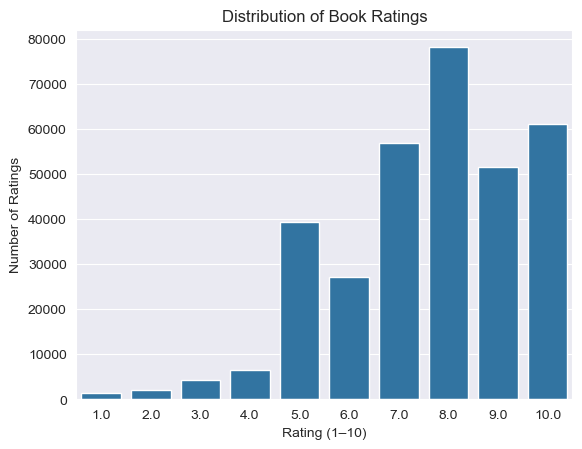

In [186]:
rating_value_counts = ratings_df["Book-Rating"].value_counts().sort_index()  # Count ratings per value
sns.barplot(x=rating_value_counts.index, y=rating_value_counts.values)  # Create bar plot
plt.title("Distribution of Book Ratings")  # Set title
plt.xlabel("Rating (1–10)")  # Set x-axis label
plt.ylabel("Number of Ratings")  # Set y-axis label
plt.show()  # Display plot


## EDA: Long Tail Distribution - Ratings per Book
# to Analyze popularity distribution of books (how many books have few/many ratings)
# Insight: Shows the "long tail" phenomenon where few books get most ratings


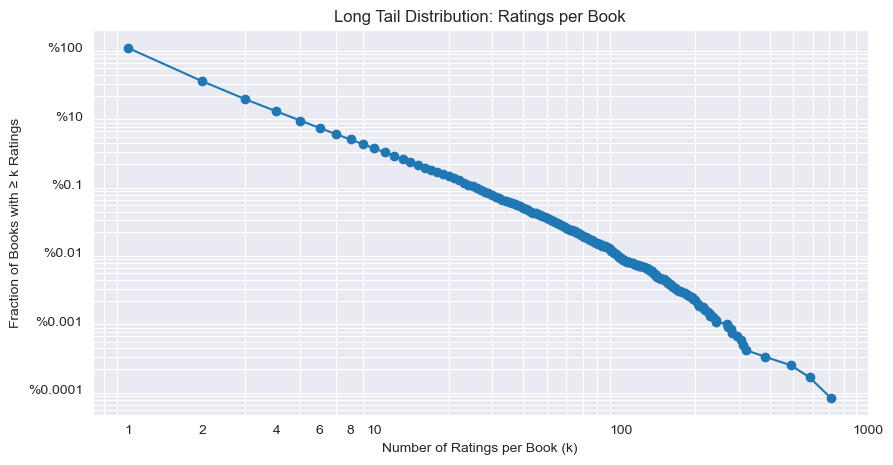

In [187]:
ratings_per_book = ratings_df["ISBN"].value_counts().rename("ratings_per_book")  # Count ratings per book
k_values = np.unique(ratings_per_book.values[::-1])  # Get unique rating counts
fraction_ge_k = [
    len(ratings_per_book[ratings_per_book >= k]) / len(ratings_per_book) for k in k_values
]  # Calculate fraction of books with ≥k ratings

plt.figure(figsize=(10, 5))  # Set figure size
plt.loglog(k_values, fraction_ge_k, marker="o", linestyle="-")  # Create log-log plot
plt.title("Long Tail Distribution: Ratings per Book")  # Set title
plt.xlabel("Number of Ratings per Book (k)")  # Set x-axis label
plt.ylabel("Fraction of Books with ≥ k Ratings")  # Set y-axis label
plt.grid(which="both")  # Add grid lines

plt.xticks([ 1 , 2 , 4 , 6 , 8 , 10 , 100 , 1000],
['1','2','4','6','8','10','100','1000'])  # Set x-ticks

plt.yticks([ 1e-5 , 1e-4 , 1e-3 , 1e-2 ,1e-1 , 1],
['%0.0001','%0.001','%0.01','%0.1','%10','%100']) # Set y-ticks

plt.show()  # Display plot


## EDA: Long Tail Distribution - Ratings per User
# to Analyze user engagement distribution (how many users rate few/many books)
# Insight: Shows if most users rate few books while few power users rate many


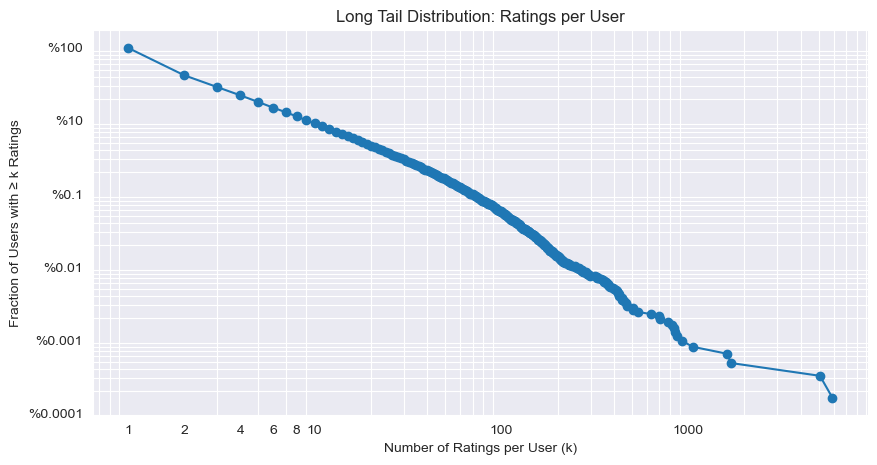

In [188]:
ratings_per_user = ratings_df["User-ID"].value_counts().rename("ratings_per_user")  # Count ratings per user
k_values_user = np.unique(ratings_per_user.values[::-1])  # Get unique rating counts
fraction_ge_k_user = [
    len(ratings_per_user[ratings_per_user >= k]) / len(ratings_per_user) for k in k_values_user
]  # Calculate fraction of users with ≥k ratings

plt.figure(figsize=(10, 5))  # Set figure size
plt.loglog(k_values_user, fraction_ge_k_user, marker="o", linestyle="-")  # Create log-log plot
plt.title("Long Tail Distribution: Ratings per User")  # Set title
plt.xlabel("Number of Ratings per User (k)")  # Set x-axis label
plt.ylabel("Fraction of Users with ≥ k Ratings")  # Set y-axis label

plt.xticks([ 1 , 2 , 4 , 6 , 8 , 10 , 100 , 1000],
['1','2','4','6','8','10','100','1000'])  # Set x-ticks

plt.yticks([ 1e-5 , 1e-4 , 1e-3 , 1e-2 ,1e-1 , 1],
['%0.0001','%0.001','%0.01','%0.1','%10','%100']) # Set y-ticks

plt.grid(which="both")  # Add grid lines
plt.show()  # Display plot


## EDA: User Avg Rating Distribution
# to Analyze how users distribute their ratings on average
# Insight: Shows if users tend to be generous/strict in their ratings overall


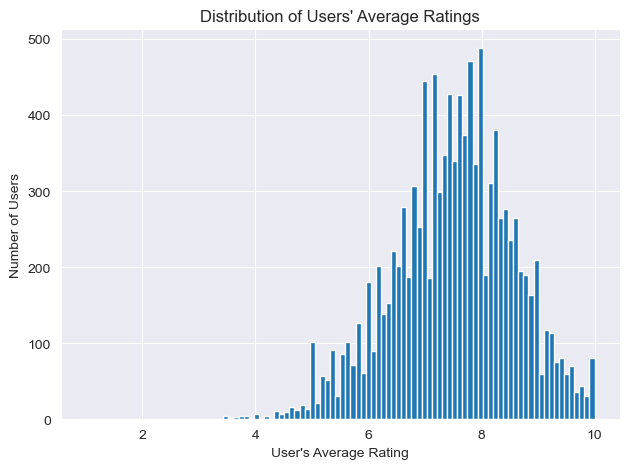

In [189]:
user_avg_ratings = (
    ratings_df.groupby("User-ID")["Book-Rating"]
    .mean()
    .rename("avg_rating")
)  # Calculate mean rating per user
user_avg_ratings = user_avg_ratings[ratings_df["User-ID"].value_counts() >= 5]  # Filter users with ≥5 ratings

plt.hist(user_avg_ratings, bins=100)  # Create histogram
plt.title("Distribution of Users' Average Ratings")  # Set title
plt.xlabel("User's Average Rating")  # Set x-axis label
plt.ylabel("Number of Users")  # Set y-axis label
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot


## Iterative Filtering – K-Core (Users & Books)
# Purpose: Remove sparse users and items to create a denser dataset
# Insight: Helps improve recommendation quality by focusing on meaningful interactions


In [190]:
ratings_df = apply_k_core_filtering(ratings_df)

## Post-Filtering Stats
# Checking statistics after k-core filtering to understand remaining data


In [191]:
print(ratings_df["User-ID"].value_counts().tail())  # Show least active remaining users
print(ratings_df["ISBN"].value_counts().tail())  # Show least popular remaining books


120696    6
120548    6
120178    6
238541    6
276688    6
Name: User-ID, dtype: int64
0385333064    8
0786883219    8
0553575422    8
0452282268    8
0316107255    8
Name: ISBN, dtype: int64


## Check for Duplicated (User, Book) Pairs
# Verifying there are no duplicate user-book rating pairs (data integrity check)


In [192]:
if True in ratings_df.duplicated(subset=["User-ID", "ISBN"]):
    print("duplicated ratings:")
    print(ratings_df[ratings_df.duplicated(subset=["User-ID", "ISBN"])]["User-ID"].value_counts())
else:
    print("no duplicated ratings")


no duplicated ratings


## Final Alignment of Users & Books
# Ensuring all remaining users and books have ratings (data consistency)


In [193]:
books_df,users_df = align_user_book_datasets(ratings_df,books_df,users_df)

## Add Password Column
# Initialise Password as the string 'u' followed by the user id

In [194]:
users_df["User-Name"] = "User-" + users_df["User-ID"].astype(str)
users_df["Password"] = "u" + users_df["User-ID"].astype(str)
users_df = users_df[["User-ID", "User-Name","Location","Age","Password"]]
users_df

,User-ID,User-Name,Location,Age,Password
113,114,User-114,"ligonier, pennsylvania, usa",57.0,u114
242,243,User-243,"arden hills, minnesota, usa",NaN,u243
243,244,User-244,"college station, texas, usa",NaN,u244
253,254,User-254,"minneapolis, minnesota, usa",24.0,u254
506,507,User-507,"dumas, arkansas, usa",NaN,u507
...,...,...,...,...,...
278417,278418,User-278418,"omaha, nebraska, usa",NaN,u278418
278534,278535,User-278535,"oshkosh, wisconsin, usa",NaN,u278535
278581,278582,User-278582,"slidell, louisiana, usa",NaN,u278582
278632,278633,User-278633,"sandy, utah, usa",NaN,u278633


# Creating Mappers

In [195]:
user_id_map, isbn_map, user_id_map_inv, isbn_map_inv = build_mappers(ratings_df)

## Final Entity Sizes
# Checking final counts of books and users to understand dataset scale


In [196]:
print(len(books_df))  # Count of remaining books
print(len(ratings_df["ISBN"].unique()))  # Count of books with ratings
print(len(users_df))  # Count of remaining users
print(len(ratings_df["User-ID"].unique()))  # Count of users with ratings


3040
3040
3422
3422


## Final Cleaned Ratings
# Displaying the final cleaned ratings dataframe for inspection


In [197]:
ratings_df  # Display the final ratings dataframe

,User-ID,ISBN,Book-Rating
911,277157,0312979517,5.0
917,277157,0345452550,7.0
928,277157,0399146504,7.0
941,277157,0399151451,7.0
945,277157,0425183181,5.0
...,...,...,...
1149711,276688,0553566040,6.0
1149715,276688,0553575104,6.0
1149738,276688,0688156134,8.0
1149743,276688,0836218655,10.0


# Save Processed Data to Files

In [198]:
ratings_df.to_csv(r"../data/processed/ratings_cleaned.csv",index = False)
books_df.to_csv(r"../data/processed/books_cleaned.csv",index = False)
users_df.to_csv(r"../data/processed/users_cleaned.csv",index = False)

In [199]:
user_id_map_str_keys = {str(k): int(v) for k, v in user_id_map.items()}
user_id_map_inv_str_keys = {str(k): int(v) for k, v in user_id_map_inv.items()}

mappers_to_save = {"user_id_map": user_id_map_str_keys,
                   "isbn_map": isbn_map,
                   "user_id_map_inv": user_id_map_inv_str_keys,
                   "isbn_map_inv": isbn_map_inv}

with open("../data/processed/mappers.json", "w") as f:
    json.dump(mappers_to_save, f, indent=4)

In [200]:
mask = books_df.loc[:,"Book-Title"].str.lower().str.contains("harry potter")
books_df[mask]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
821,0767908473,The Sorcerer's Companion: A Guide to the Magical World of Harry Potter,ALLAN ZOLA KRONZEK,2001,Broadway,http://images.amazon.com/images/P/0767908473.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767908473.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767908473.01.LZZZZZZZ.jpg
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590353403.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590353403.01.LZZZZZZZ.jpg
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.LZZZZZZZ.jpg
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439136350.01.LZZZZZZZ.jpg
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.LZZZZZZZ.jpg
5506,043935806X,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.LZZZZZZZ.jpg
79370,0439425220,Harry Potter and the Chamber of Secrets Postcard Book,J. K. Rowling,2002,Scholastic,http://images.amazon.com/images/P/0439425220.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439425220.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439425220.01.LZZZZZZZ.jpg


In [201]:
pd.DataFrame([i for i in ratings_df.groupby("User-ID")['ISBN']])

,0,1
0,114,"9690 0446608653 9691 0446612545 9692 0446612618 9693 0451208080 9694 0553584383 9695 0671027360 Name: ISBN, dtype: object"
1,243,"9955 0060915544 9956 0060977493 9962 0316601950 9966 0316776963 9967 0316899984 9976 0375400117 10001 044023722X 10009 0446606383 10012 0449006522 10035 155874262X Name: ISBN, dtype: object"
2,244,"10036 0060977493 10037 0060987103 10038 0151008116 10040 0525947647 10041 0804111359 10042 155874262X 10043 1558744150 Name: ISBN, dtype: object"
3,254,"10057 0060934700 10071 0064471047 10073 0066238501 10084 0142001740 10132 0373226144 10186 0380789035 10190 0380973650 10202 0399146431 10209 0439064872 10210 0439136350 10212 0439139597 10243 0451167317 10248 0451409256 10251 0451524934 10253 0451526341 10279 0590353403 10284 0618002219 10290 0671021001 Name: ISBN, dtype: object"
4,507,"10792 0020427859 10803 0142001740 10847 0451184718 10856 0553564528 10859 0553575538 10860 0553576801 10862 055357695X 10867 0553583441 10868 0553583468 10885 0689710879 10886 0689710887 10887 0689710895 10888 0689711522 10890 0743260244 10910 0821772953 Name: ISBN, dtype: object"
...,...,...
3417,278418,"5022 0345369335 5985 0394800168 5990 0394820371 6155 042513525X 6186 042518630X 6331 0440184622 6349 0440207622 6747 0515130389 6749 0515131229 6911 0553297988 Name: ISBN, dtype: object"
3418,278535,"8980 0061094129 8995 0425182878 8998 0440221595 9002 0446605484 9003 0446610038 9004 0446611212 9005 0449003787 9007 0449219461 9008 0553213180 9009 0553269216 Name: ISBN, dtype: object"
3419,278582,"9131 0312983298 9132 0312983867 9135 0312990456 9136 0312991460 9138 0345350499 9141 0425163717 9144 0425191583 9147 0441478123 9148 0449003183 9151 0449221512 9153 0451202503 9161 0671001795 9170 1400034779 Name: ISBN, dtype: object"
3420,278633,"9197 0060987561 9198 0140244824 9200 0140296298 9202 0142000205 9204 0316096199 9205 0316666343 9206 0316899984 9210 0375703063 9227 0449907481 9228 0451163524 9235 0515131083 9240 0553278355 9246 0671038184 9253 0684814994 9256 0688162827 9257 0688170528 9258 0743225082 Name: ISBN, dtype: object"


In [202]:
books_df[books_df["ISBN"] == "0439064872"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.LZZZZZZZ.jpg


In [203]:
ratings_df[ratings_df["User-ID"] == 274380]

,User-ID,ISBN,Book-Rating
1142334,274380,0060928336,8.0
1142338,274380,0380002450,7.0
1142344,274380,0451523415,9.0
1142346,274380,0553272535,9.0
1142347,274380,059035342X,9.0
1142349,274380,0671617028,8.0
1142351,274380,0743412028,7.0
1142352,274380,0804106304,8.0


In [204]:
114 in ratings_df.groupby("User-ID")["ISBN"].unique() and '0446608653' in ratings_df.groupby("User-ID")["ISBN"].unique().loc[114]

True

In [205]:
ratings_df.groupby("User-ID")["ISBN"].unique()

User-ID
114                                                                                                                                                       [0446608653, 0446612545, 0446612618, 0451208080, 0553584383, 0671027360]
243                                                                                                       [0060915544, 0060977493, 0316601950, 0316776963, 0316899984, 0375400117, 044023722X, 0446606383, 0449006522, 155874262X]
244                                                                                                                                           [0060977493, 0060987103, 0151008116, 0525947647, 0804111359, 155874262X, 1558744150]
254       [0060934700, 0064471047, 0066238501, 0142001740, 0373226144, 0380789035, 0380973650, 0399146431, 0439064872, 0439136350, 0439139597, 0451167317, 0451409256, 0451524934, 0451526341, 0590353403, 0618002219, 0671021001]
507                                           [0020427859, 0142001740, 0451184718, 0